In [77]:
import gym
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

class Agent():
    def __init__(self,
                 num_episodes=1000, 
                 min_lr=0.1, 
                 min_epsilon=0.1, 
                 discount=1.0, 
                 decay=25):
        self.buckets = (1, 1, 6, 12)
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay
        self.algo_type = 'q'

#         self.env = gym.make('CartPole-v0')
#         gym.envs.register(
#             id='CartPoleExtraLong-v0',
#             entry_point='gym.envs.classic_control:CartPoleEnv',
#             max_episode_steps=10000
#         )
        self.env = gym.make('CartPoleExtraLong-v0')

        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]

        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))

    def discretize_state(self, obs):
        discretized = list()
        for i in range(len(obs)):
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def choose_action(self, state):
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])

    def update_sarsa(self, state, action, reward, new_state, new_action):
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * (self.Q_table[new_state][new_action]) - self.Q_table[state][action])    

    def update_q(self, state, action, reward, new_state):
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])

    def update_epsilon(self, t):
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    def update_learning_rate(self, t):
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def train(self):
        rewards = []
        for e in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())
            self.learning_rate = self.update_learning_rate(e)
            self.epsilon = self.update_epsilon(e)
            done = False
            if e%100 ==0:
                print(e)
            t=0
            best_result = 0
            while not done:
                t += 1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                
                if self.algo_type == 'q':
                    self.update_q(current_state, action, reward, new_state)
                else:
                    new_action = self.choose_action(new_state)
                    self.update_sarsa(current_state, action, reward, new_state, new_action)
                
                current_state = new_state
            
                if best_result < t:
                    best_result = t
            
            rewards.append(t)
        print('Finished training')
        plt.plot(rewards)
        pd.DataFrame({'reward':rewards}).to_csv('rewards_log.csv')

    def run_and_render(self):
        
        self.env = gym.wrappers.Monitor(self.env,'./workshop/', force=True)
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
                
        return t   

0
100
200
300
400
500
600
700
800
900
Finished training


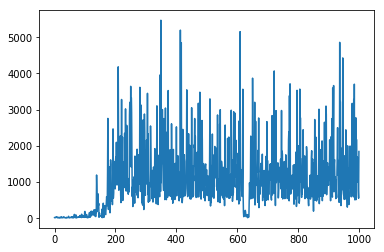

In [78]:
agent = Agent(num_episodes=1000)
agent.train()

In [73]:

for i in range(100):
    t = agent.run_and_render()
    print("Time", t)

Time 1959


In [81]:
t = agent.run_and_render()
print("Time", t)

Time 1252


In [70]:
df = pd.read_csv('rewards_log.csv')
rewards = df.reward.values.ravel()

Text(0, 0.5, 'Time [s]')

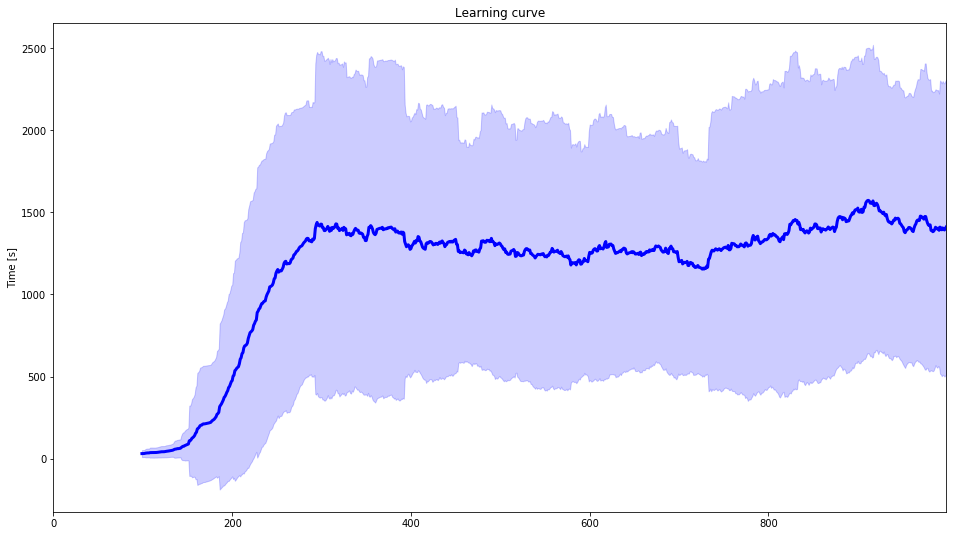

In [75]:
plt.figure(figsize=(16, 9))
# plt.plot(rewards, 'o')
means = df.reward.rolling(window=100).mean()
stds = df.reward.rolling(window=100).std()
means.plot(linewidth=3, color='blue')
plt.fill_between(x=means.index, y1=means-stds, y2=means+stds, alpha=0.2, color='blue')
plt.title('Learning curve')
plt.ylabel("Time [s]")

In [80]:
df.reward.mean()

1123.971